## imports 

In [14]:
!pip uninstall -y torch

Found existing installation: torch 2.8.0

You can safely remove it manually.



Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0


In [15]:
!pip install torch==2.3.1

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.89 requires torchvision>=0.9.0, which is not installed.



   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.8/159.8 MB 2.6 MB/s eta 0:01:02
   ---------------------------------------- 1.6/159.8 MB 3.1 MB/s eta 0:00:51
    --------------------------------------- 2.4/159.8 MB 3.4 MB/s eta 0:00:47
    --------------------------------------- 3.1/159.8 MB 3.5 MB/s eta 0:00:45
    --------------------------------------- 3.9/

In [1]:
import torch
print(torch.__version__)

2.3.1+cpu


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## load dataset

In [4]:
drugs = pd.read_csv("drugs.csv")
proteins = pd.read_csv("proteins.csv")
affinity = pd.read_csv("drug_protein_affinity.csv")

print(drugs.shape, drugs.columns)
print(proteins.shape, proteins.columns)
print(affinity.shape, affinity.columns)

(68, 4) Index(['Drug_Index', 'CID', 'Canonical_SMILES', 'Isomeric_SMILES'], dtype='object')
(433, 4) Index(['Protein_Index', 'Accession_Number', 'Gene_Name', 'Sequence'], dtype='object')
(29444, 3) Index(['Drug_Index', 'Protein_Index', 'Affinity'], dtype='object')


## Feature engineering (fallback without RDKit/PyG)

In [5]:
# Simple SMILES hashing (works without RDKit)
def smiles_to_vec(smiles, dim=256):
    v = np.zeros(dim, dtype=np.float32)
    for c in smiles:
        v[hash(c) % dim] += 1
    return v / (np.linalg.norm(v) + 1e-6)

# Protein amino-acid composition
def seq_to_aac(seq):
    letters = "ACDEFGHIKLMNPQRSTVWY"
    counts = np.array([seq.count(aa) for aa in letters], dtype=np.float32)
    return counts / (np.sum(counts) + 1e-6)

drug_features = {row.Drug_Index: smiles_to_vec(row.Canonical_SMILES) 
                 for _, row in drugs.iterrows()}
protein_features = {row.Protein_Index: seq_to_aac(row.Sequence) 
                    for _, row in proteins.iterrows()}

## Dataset wrapper

In [6]:
class DTIDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        d_feat = drug_features[row.Drug_Index]
        p_feat = protein_features[row.Protein_Index]
        x = np.concatenate([d_feat, p_feat])
        y = row.Affinity
        return torch.tensor(x, dtype=torch.float32), torch.tensor([y], dtype=torch.float32)

## train/test split

In [7]:
train_df, test_df = train_test_split(affinity, test_size=0.2, random_state=42)

train_ds = DTIDataset(train_df)
test_ds = DTIDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# MLP model

In [8]:
class MLPRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

in_dim = len(next(iter(drug_features.values()))) + len(next(iter(protein_features.values())))
mlp_model = MLPRegressor(in_dim)

## Training loop

In [9]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()

        # eval
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds.append(model(xb).cpu().numpy())
                trues.append(yb.cpu().numpy())
        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        rmse = mean_squared_error(trues, preds, squared=False)
        print(f"Epoch {epoch+1}/{epochs} | Test RMSE: {rmse:.4f}")
    return model

mlp_model = train_model(mlp_model, train_loader, test_loader, epochs=10)

Epoch 1/10 | Test RMSE: 0.8533
Epoch 2/10 | Test RMSE: 0.8370
Epoch 3/10 | Test RMSE: 0.8490
Epoch 4/10 | Test RMSE: 0.8487
Epoch 5/10 | Test RMSE: 0.8681
Epoch 6/10 | Test RMSE: 0.8491
Epoch 7/10 | Test RMSE: 0.8321
Epoch 8/10 | Test RMSE: 0.8148
Epoch 9/10 | Test RMSE: 0.8531
Epoch 10/10 | Test RMSE: 0.8376


# KG-style embedding model

## Remap indices

In [12]:
# Remap Drug_Index and Protein_Index to 0...N-1
drug_id_map = {old: new for new, old in enumerate(sorted(drugs['Drug_Index'].unique()))}
protein_id_map = {old: new for new, old in enumerate(sorted(proteins['Protein_Index'].unique()))}

affinity['Drug_Index'] = affinity['Drug_Index'].map(drug_id_map)
affinity['Protein_Index'] = affinity['Protein_Index'].map(protein_id_map)

num_drugs = len(drug_id_map)
num_proteins = len(protein_id_map)

print(f"Drugs remapped: {num_drugs}, Proteins remapped: {num_proteins}")

# Split again after remap
train_df, test_df = train_test_split(affinity, test_size=0.2, random_state=42)

Drugs remapped: 68, Proteins remapped: 433


## KG model definition

In [13]:
class KGEmbedRegressor(nn.Module):
    def __init__(self, n_drugs, n_proteins, embed_dim=64):
        super().__init__()
        self.drug_emb = nn.Embedding(n_drugs, embed_dim)
        self.protein_emb = nn.Embedding(n_proteins, embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, d_idx, p_idx):
        d = self.drug_emb(d_idx)
        p = self.protein_emb(p_idx)
        return self.fc(torch.cat([d,p], dim=-1))

## Dataset + DataLoaders

In [14]:
class KGDset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return (
            torch.tensor(row.Drug_Index, dtype=torch.long),
            torch.tensor(row.Protein_Index, dtype=torch.long),
            torch.tensor([row.Affinity], dtype=torch.float32)
        )

kg_train = DataLoader(KGDset(train_df), batch_size=64, shuffle=True)
kg_test = DataLoader(KGDset(test_df), batch_size=64)

## training loop

In [15]:
kg_model = KGEmbedRegressor(num_drugs, num_proteins)
opt = torch.optim.Adam(kg_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kg_model.to(device)

for epoch in range(10):
    # Training
    kg_model.train()
    for d, p, y in kg_train:
        d,p,y = d.to(device), p.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(kg_model(d,p), y)
        loss.backward()
        opt.step()

    # Evaluation
    kg_model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for d,p,y in kg_test:
            d,p,y = d.to(device), p.to(device), y.to(device)
            preds.append(kg_model(d,p).cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    rmse = mean_squared_error(trues, preds, squared=False)
    print(f"Epoch {epoch+1}/10 | KG Test RMSE: {rmse:.4f}")

Epoch 1/10 | KG Test RMSE: 0.8003
Epoch 2/10 | KG Test RMSE: 0.7756
Epoch 3/10 | KG Test RMSE: 0.7654
Epoch 4/10 | KG Test RMSE: 0.7581
Epoch 5/10 | KG Test RMSE: 0.7493
Epoch 6/10 | KG Test RMSE: 0.7376
Epoch 7/10 | KG Test RMSE: 0.7340
Epoch 8/10 | KG Test RMSE: 0.7222
Epoch 9/10 | KG Test RMSE: 0.7277
Epoch 10/10 | KG Test RMSE: 0.7043


# Model camprison

MLP Test RMSE: 0.8376
KG Test RMSE: 0.7043


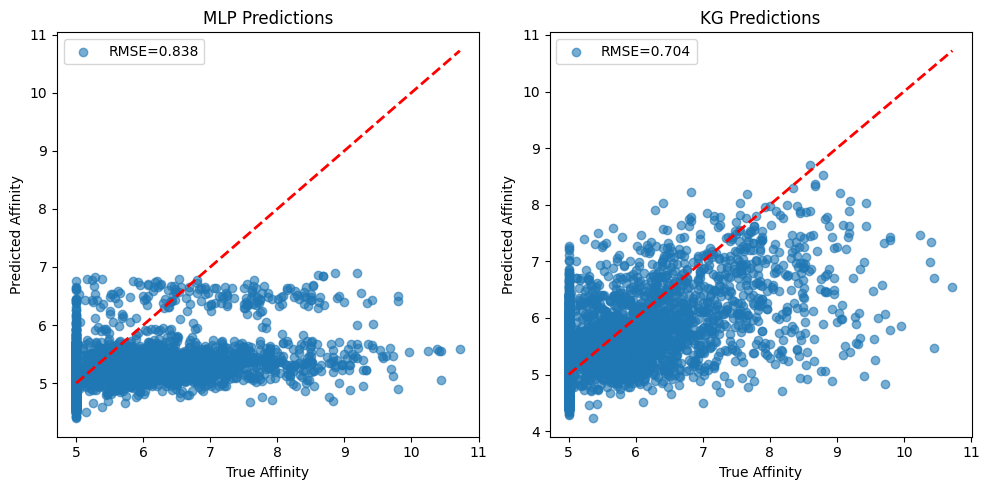

In [23]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def evaluate(model, test_loader, name="Model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 2:  # MLP: (xb, yb)
                xb, yb = batch
                xb, yb = xb.to(device), yb.to(device)
                preds.append(model(xb).cpu().numpy())
                trues.append(yb.cpu().numpy())
            else:  # KG: (d, p, y)
                d, p, y = batch
                d,p,y = d.to(device), p.to(device), y.to(device)
                preds.append(model(d,p).cpu().numpy())
                trues.append(y.cpu().numpy())
    preds = np.concatenate(preds).flatten()
    trues = np.concatenate(trues).flatten()
    rmse = mean_squared_error(trues, preds, squared=False)
    print(f"{name} Test RMSE: {rmse:.4f}")
    return trues, preds, rmse

# --- Run evaluations ---
mlp_trues, mlp_preds, mlp_rmse = evaluate(mlp_model, test_loader, "MLP")
kg_trues,  kg_preds,  kg_rmse  = evaluate(kg_model, kg_test, "KG")

# --- Visualization ---
plt.figure(figsize=(10,5))

# MLP scatter
plt.subplot(1,2,1)
plt.scatter(mlp_trues, mlp_preds, alpha=0.6, label=f"RMSE={mlp_rmse:.3f}")
plt.plot([mlp_trues.min(), mlp_trues.max()],
         [mlp_trues.min(), mlp_trues.max()], 'r--', lw=2)
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("MLP Predictions")
plt.legend()

# KG scatter
plt.subplot(1,2,2)
plt.scatter(kg_trues, kg_preds, alpha=0.6, label=f"RMSE={kg_rmse:.3f}")
plt.plot([kg_trues.min(), kg_trues.max()],
         [kg_trues.min(), kg_trues.max()], 'r--', lw=2)
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("KG Predictions")
plt.legend()

plt.tight_layout()
plt.show()